In [91]:
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pyspark.sql.functions
from pyspark.sql.functions import col
from pyspark.sql.functions import udf, array
from pyspark.sql.functions import count
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from datashader.utils import lnglat_to_meters
import bokeh.plotting as bp
from bokeh.models.tiles import WMTSTileSource
import datashader as ds
import datashader.transfer_functions as tf
from datashader.bokeh_ext import InteractiveImage
from datashader.utils import export_image
import colorcet as cc
import os
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import CARTODBPOSITRON


In [2]:
sc = SparkContext(appName="BigData")
spark = SQLContext (sc)

In [3]:
agency = spark.read.option("header", True).option("sep", ",").csv("data/agency.txt") 
calendar_dates = spark.read.option("header", True).option("sep", ",").csv("data/calendar_dates.txt") 
feed_info = spark.read.option("header", True).option("sep", ",").csv("data/feed_info.txt") 
pathways = spark.read.option("header", True).option("sep", ",").csv("data/pathways.txt")
routes = spark.read.option("header", True).option("sep", ",").csv("data/routes.txt")
shapes = spark.read.option("header", True).option("sep", ",").csv("data/shapes.txt")
stop_times = spark.read.option("header", True).option("sep", ",").csv("data/stop_times.txt") #nagy
stops = spark.read.option("header", True).option("sep", ",").csv("data/stops.txt")
trips = spark.read.option("header", True).option("sep", ",").csv("data/trips.txt")

In [4]:
ejszakai = ['M2', 'M4', 'H5', 'H6', 'H8', 'H9',
            '6',
            '901', '907', '908', '909', '914', '914A',
            '916', '918', '922', '923', '930', '931',
            '934', '937', '938', '940', '941', '943',
            '948', '950', '950A', '956', '963', '964',
            '966', '968', '972', '972', '972B', '973',
            '979', '979A', '980', '990', '992', '994',
            '994', '996', '996A', '998', '999']

In [5]:
agency.printSchema()

root
 |-- agency_id: string (nullable = true)
 |-- agency_name: string (nullable = true)
 |-- agency_url: string (nullable = true)
 |-- agency_timezone: string (nullable = true)
 |-- agency_lang: string (nullable = true)
 |-- agency_phone: string (nullable = true)



In [6]:
ejszakai_routes = routes.filter(col("route_short_name").isin(ejszakai))
ejszakai_routes.limit(1).show()

+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+
|agency_id|route_id|route_short_name|route_long_name|route_type|          route_desc|route_color|route_text_color|
+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+
|      BKK|    3060|               6|           null|         0|Széll Kálmán tér ...|     FFD800|          000000|
+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+



In [7]:

convert_udf = udf(lambda x: int(x.split(":")[0])*60 + int(x.split(":")[1]), IntegerType())

stop_times = stop_times.withColumn('arrival_time_new', convert_udf(stop_times.arrival_time))

#stop_times["arrival_time"] = stop_times["arrival_time"].apply(lambda x: int(x.split(":")[0])*60 + int(x.split(":")[1]))

In [10]:
ejszakai_arrival_time = stop_times.filter(col("arrival_time_new") >= 24*60)

In [9]:
ejszakai_routeids = ejszakai_routes.select("route_id").rdd.flatMap(lambda x: x).collect()
ejszakai_trips_temp = trips.filter(col("route_id").isin(ejszakai_routeids))
ejszakai_arrival_time_tripids = ejszakai_arrival_time.select("trip_id").rdd.flatMap(lambda x: x).collect()
ejszakai_trips = ejszakai_trips_temp.filter(col("trip_id").isin(ejszakai_arrival_time_tripids))
ejszakai_trips.select([count(c).alias(c) for c in ejszakai_trips.columns]).show()
#ejszakai_trips_temp = trips[trips["route_id"].isin(ejszakai_routes["route_id"])]
#ejszakai_trips = ejszakai_trips_temp[ejszakai_trips_temp["trip_id"].isin(ejszakai_arrival_time["trip_id"])]
#ejszakai_trips.count()


+--------+-------+----------+-------------+------------+--------+--------+---------------------+-------------+-------------+
|route_id|trip_id|service_id|trip_headsign|direction_id|block_id|shape_id|wheelchair_accessible|bikes_allowed|boarding_door|
+--------+-------+----------+-------------+------------+--------+--------+---------------------+-------------+-------------+
|    2936|   2936|      2936|         2936|        2936|    2936|    2936|                 2936|         2931|         1342|
+--------+-------+----------+-------------+------------+--------+--------+---------------------+-------------+-------------+



In [11]:
ejszakai_trips_per_shape = ejszakai_trips.groupby('shape_id').agg(count(col("route_id")))
ejszakai_trips_per_shape=ejszakai_trips_per_shape.withColumnRenamed("route_id", "trip_count")

ejszakai_shape_suruseg = shapes.join(ejszakai_trips_per_shape, on='shape_id')
ejszakai_shape_suruseg.show()

+--------+-----------------+------------+------------+-------------------+---------------+
|shape_id|shape_pt_sequence|shape_pt_lat|shape_pt_lon|shape_dist_traveled|count(route_id)|
+--------+-----------------+------------+------------+-------------------+---------------+
|    1111|           100001|   47.502885|   19.135571|                0.0|             15|
|    1111|           100002|   47.502843|   19.135591|                2.0|             15|
|    1111|           100003|   47.502754|   19.134754|               66.0|             15|
|    1111|           100004|   47.502691|   19.133931|              128.0|             15|
|    1111|           100005|   47.502674|   19.133334|              173.0|             15|
|    1111|           100006|   47.502653|   19.132850|              209.0|             15|
|    1111|           100007|   47.502099|   19.127778|              596.0|             15|
|    1111|           100008|   47.501742|   19.124446|              850.0|             15|

In [12]:
#Ez miért nem megy?
ejszakai_shape_suruseg_pandas = ejszakai_shape_suruseg.toPandas()

ejszakai_shape_suruseg_pandas['coord_x'], ejszakai_shape_suruseg_pandas['coord_y'] = \
    lnglat_to_meters(np.asarray(list(ejszakai_shape_suruseg_pandas['shape_pt_lon']), dtype='float64'), np.asarray(list(ejszakai_shape_suruseg_pandas['shape_pt_lat']), dtype='float64'))

def split_df_by(df, byvar):
    df_parts = []
    for level, df_part in df.groupby(byvar):
        empty = pd.DataFrame([[level if colname == byvar else np.NaN for colname in df.columns]],
                             columns=df.columns)
        df_parts.append(df_part.append(empty))
    return pd.concat(df_parts) 

ejszakai_shapes = split_df_by(ejszakai_shape_suruseg_pandas, 'shape_id')
ejszakai_shapes.head()

,shape_id,shape_pt_sequence,shape_pt_lat,shape_pt_lon,shape_dist_traveled,count(route_id),coord_x,coord_y
0,1111,100001,47.502885,19.135571,0.0,15.0,2.130162e+06,6.024548e+06
1,1111,100002,47.502843,19.135591,2.0,15.0,2.130164e+06,6.024541e+06
2,1111,100003,47.502754,19.134754,66.0,15.0,2.130071e+06,6.024526e+06
3,1111,100004,47.502691,19.133931,128.0,15.0,2.129979e+06,6.024516e+06
4,1111,100005,47.502674,19.133334,173.0,15.0,2.129913e+06,6.024513e+06


In [15]:
bp.output_notebook()

x_range=(2.101e6, 2.155e6)
y_range=(5.994e6, 6.052e6)

if not os.path.exists('./img'):
    os.mkdir('./img')
    
p = bp.figure(tools='pan,wheel_zoom,reset',
              plot_width=int(900),
              plot_height=int(900),
              x_range=x_range,
              y_range=y_range)

p.axis.visible = False
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

url = "https://cartodb-basemaps-b.global.ssl.fastly.net/dark_all/{z}/{x}/{y}.png"
tile_renderer = p.add_tile(WMTSTileSource(url=url))
tile_renderer.alpha = 1

def image_callback(x_range, y_range, w, h, color_fn=tf.shade):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.line(ejszakai_shapes, 'coord_x', 'coord_y', agg=ds.sum('trip_count'))
    image = tf.shade(agg, cmap=cc.fire, how='eq_hist')
    return image

export_image(image_callback(x_range=x_range, y_range=y_range, w=2000, h=2000),
             filename="BUD_schedule_fire", background='black')
InteractiveImage(p, image_callback)

Loading BokehJS ...

ValueError: specified column not found

In [14]:
calendar_dates.limit(10).show()

+------------------+--------+--------------+
|        service_id|    date|exception_type|
+------------------+--------+--------------+
| A9113924SZKP-0011|20181224|             1|
|A92244EVVHPKP-0011|20181227|             1|
|A92244EVVHPKP-0011|20181228|             1|
|B03211EVVHPKM-0011|20181227|             1|
|B03211EVVHPKM-0011|20181228|             1|
|B03247EVVHPKM-0011|20181227|             1|
|B03247EVVHPKM-0011|20181228|             1|
|  B05716AHPKP-0011|20181110|             1|
|  B05716AHPKP-0011|20181112|             1|
|  B05716AHPKP-0011|20181113|             1|
+------------------+--------+--------------+



In [15]:
pathways.limit(10).show()

+-------------+------------+------------+----------+--------------+-------------------------+
|   pathway_id|pathway_type|from_stop_id|to_stop_id|traversal_time|wheelchair_traversal_time|
+-------------+------------+------------+----------+--------------+-------------------------+
|LM4KF1-LM4KFA|           3|      LM4KF1|    LM4KFA|            30|                       -1|
|LM4KF1-LM4KFB|           3|      LM4KF1|    LM4KFB|           150|                       -1|
|LM4KF1-LM4KFC|           3|      LM4KF1|    LM4KFC|           150|                       -1|
|LM4KF1-LM4KFD|           3|      LM4KF1|    LM4KFD|           180|                       -1|
|LM1OPV-F01079|           1|      LM1OPV|    F01079|            30|                       -1|
|LM1DF1-F00962|           1|      LM1DF1|    F00962|            30|                       -1|
|F01749-LM2OV1|           1|      F01749|    LM2OV1|            30|                       60|
|F00937-LM3NY1|           1|      F00937|    LM3NY1|        

In [16]:
routes.limit(10).show()

+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+
|agency_id|route_id|route_short_name|route_long_name|route_type|          route_desc|route_color|route_text_color|
+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+
|      BKK|    0050|               5|           null|         3|Pasaréti tér / Rá...|     009FE3|          FFFFFF|
|      BKK|    0070|               7|           null|         3|Albertfalva vasút...|     009FE3|          FFFFFF|
|      BKK|    0075|              7E|           null|         3|Blaha Lujza tér M...|     009FE3|          FFFFFF|
|      BKK|    0078|              7G|           null|         3|Cinkotai autóbusz...|     009FE3|          FFFFFF|
|      BKK|    0085|              8E|           null|         3|Kelenföld vasútál...|     009FE3|          FFFFFF|
|      BKK|    0090|               9|           null|         3|Óbuda, Bogdáni ú

In [17]:
routes[routes.route_short_name == "923"].limit(10).show()

+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+
|agency_id|route_id|route_short_name|route_long_name|route_type|          route_desc|route_color|route_text_color|
+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+
|      BKK|    9230|             923|           null|         3|Békásmegyer H / D...|     1E1E1E|          FFFFFF|
+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+



In [18]:
shapes.limit(100).show()

+--------+-----------------+------------+------------+-------------------+
|shape_id|shape_pt_sequence|shape_pt_lat|shape_pt_lon|shape_dist_traveled|
+--------+-----------------+------------+------------+-------------------+
|    0285|           100001|   47.519630|   19.148313|                0.0|
|    0285|           100002|   47.519657|   19.148286|                4.0|
|    0285|           100003|   47.519839|   19.148638|               35.0|
|    0285|           100004|   47.520584|   19.150246|              182.0|
|    0285|           100005|   47.520674|   19.150432|              199.0|
|    0285|           100006|   47.520727|   19.150486|              206.0|
|    0285|           100007|   47.520790|   19.150512|              213.0|
|    0285|           100008|   47.520988|   19.150964|              253.0|
|    0285|           100009|   47.521320|   19.151695|              319.0|
|    0285|           100010|   47.521543|   19.152207|              367.0|
|    0285|           1000

In [19]:
stop_times.limit(100).show()

+---------+-------+------------+--------------+-------------+-------------+-----------+-------------+-------------------+----------------+
|  trip_id|stop_id|arrival_time|departure_time|stop_sequence|stop_headsign|pickup_type|drop_off_type|shape_dist_traveled|arrival_time_new|
+---------+-------+------------+--------------+-------------+-------------+-----------+-------------+-------------------+----------------+
|  A911391| F04272|    04:25:00|      04:25:00|            0|         null|       null|         null|                0.0|             265|
|  A911391| F04184|    04:27:00|      04:27:00|            1|         null|       null|         null|              648.0|             267|
|  A911391| F04319|    04:29:00|      04:29:00|            2|         null|       null|         null|             1224.0|             269|
|  A911391| F04369|    04:32:00|      04:32:00|            3|         null|       null|         null|             2779.0|             272|
|  A911391| 008264|    04:3

In [20]:
stop_times.filter(stop_times.stop_id == "F04272").limit(10).show()

+---------+-------+------------+--------------+-------------+-------------+-----------+-------------+-------------------+----------------+
|  trip_id|stop_id|arrival_time|departure_time|stop_sequence|stop_headsign|pickup_type|drop_off_type|shape_dist_traveled|arrival_time_new|
+---------+-------+------------+--------------+-------------+-------------+-----------+-------------+-------------------+----------------+
|  A911391| F04272|    04:25:00|      04:25:00|            0|         null|       null|         null|                0.0|             265|
| A9113910| F04272|    07:34:00|      07:34:00|            5|         null|       null|         null|             6690.0|             454|
|A91139100| F04272|    14:01:00|      14:01:00|            5|         null|       null|         null|             6690.0|             841|
|A91139101| F04272|    14:08:00|      14:08:00|            0|         null|       null|         null|                0.0|             848|
|A91139102| F04272|    14:4

In [21]:
stops.limit(10).show()

+-------+--------------------+---------+---------+---------+-------------+--------------+-------------------+--------------+
|stop_id|           stop_name| stop_lat| stop_lon|stop_code|location_type|parent_station|wheelchair_boarding|stop_direction|
+-------+--------------------+---------+---------+---------+-------------+--------------+-------------------+--------------+
| 002133|Örs vezér tere M+...|47.500366|19.135700|     null|         null|          null|                  2|          null|
| 002136|   Fogas üzem (kapu)|47.509119|19.014403|     null|         null|          null|               null|          null|
| 002138|Kőbánya alsó vasú...|47.483139|19.127891|     null|         null|          null|                  2|          null|
| 003002|Puskás Ferenc Sta...|47.500368|19.103406|     null|         null|          null|                  2|          null|
| 003105|Bécsi út / Vörösv...|47.548817|19.029722|     null|         null|          null|                  2|          null|


In [24]:
trips.select("route_id", "trip_id", "trip_headsign").limit(10).show()

+--------+---------+-------------+
|route_id|  trip_id|trip_headsign|
+--------+---------+-------------+
|    6300|  A911391|Boráros tér H|
|    6300| A9113910|       Csepel|
|    6300|A91139100|       Csepel|
|    6300|A91139101|Boráros tér H|
|    6300|A91139102|       Csepel|
|    6300|A91139103|Boráros tér H|
|    6300|A91139104|       Csepel|
|    6300|A91139105|Boráros tér H|
|    6300|A91139106|       Csepel|
|    6300|A91139108|Boráros tér H|
+--------+---------+-------------+



In [23]:
trips.count()

284187

In [17]:
stops.describe()

DataFrame[summary: string, stop_id: string, stop_name: string, stop_lat: string, stop_lon: string, stop_code: string, location_type: string, parent_station: string, wheelchair_boarding: string, stop_direction: string]

In [31]:
def intdate(n):
    arr = n.split(':')
    return int(arr[0])*60*60+int(arr[1])*60+int(arr[2])

In [32]:
ll = list(map(intdate, stop_times['arrival_time']))

(0.0, 29870.0)

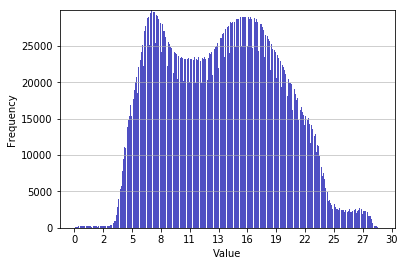

In [33]:
fig, ax = plt.subplots()
n, bins, patches = plt.hist(x=ll, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
def price(x, n):
    ora = x//(60*60)
    return int(ora)
ax.xaxis.set_major_locator(plt.MaxNLocator(12))

ax.xaxis.set_major_formatter(plt.FuncFormatter(price))

maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [104]:
max(ll)//(60*60)

29

In [115]:
def col0(n):
    arr = n.split(':')
    return int(arr[0])
ll = list(map(col0, stop_times['arrival_time']))
max(ll)

29

In [116]:
def col0(n):
    arr = n.split(':')
    return int(arr[1])
lll = list(map(col0, stop_times['arrival_time']))
max(lll)

59

In [14]:
(list(routes[routes['route_short_name'].isin(ejszakai)]['route_short_name']))

['6',
 'M2',
 'M4',
 'H8',
 'H8',
 'H9',
 'H6',
 'H6',
 'H6',
 'H5',
 'H5',
 '901',
 '907',
 '908',
 '909',
 '914',
 '914A',
 '916',
 '918',
 '922',
 '923',
 '930',
 '931',
 '934',
 '937',
 '938',
 '940',
 '941',
 '943',
 '948',
 '950',
 '950A',
 '956',
 '963',
 '964',
 '966',
 '968',
 '972',
 '972B',
 '973',
 '979',
 '979A',
 '980',
 '990',
 '992',
 '994',
 '996',
 '996A',
 '998',
 '999',
 'H6',
 '6']

In [30]:
routes.filter(col("route_short_name") == "909").show()

+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+
|agency_id|route_id|route_short_name|route_long_name|route_type|          route_desc|route_color|route_text_color|
+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+
|      BKK|    9090|             909|           null|         3|Deák Ferenc tér M...|     1E1E1E|          FFFFFF|
+---------+--------+----------------+---------------+----------+--------------------+-----------+----------------+



In [80]:

#Egy megallonevhez tartozo megallok
stop_ids = stops.filter(col("stop_name").like("%Harminckettesek%")).select("stop_id").rdd.flatMap(lambda x: x).collect()

#A stop_ids helyen megálló járművek (a hét minden napja benne van még)
stops_week = stop_times.filter(col("stop_id").isin(stop_ids)).select("trip_id", "stop_id", "arrival_time").sort("arrival_time")

stops_week.show()

+------------+-------+------------+
|     trip_id|stop_id|arrival_time|
+------------+-------+------------+
| B6621147801| F01199|    00:13:00|
| B7752255127| F01199|    00:13:00|
| B6626647801| F01199|    00:13:00|
| B8745455127| F01199|    00:13:00|
|B76861114960| F01199|    00:13:00|
| B7749641585| F01199|    00:13:00|
|B87463114960| F01199|    00:13:00|
|B89263114960| F01199|    00:13:00|
| B8776941585| F01199|    00:13:00|
| B8781832740| F01199|    00:13:00|
| B7752755127| F01199|    00:13:00|
| B7898832740| F01199|    00:13:00|
|B86108114960| F01199|    00:13:00|
| B8776941591| F01199|    00:23:00|
| B7749641591| F01199|    00:23:00|
| B7898832752| F01199|    00:23:00|
| B8781832752| F01199|    00:23:00|
| B8776934682| F01197|    00:24:00|
| B7749634682| F01197|    00:24:00|
| B8781826517| F01197|    00:24:00|
+------------+-------+------------+
only showing top 20 rows



In [81]:

ejszakai_routes_list = routes.filter(col("route_short_name").isin(ejszakai)).rdd.flatMap(lambda x: x).collect()

ejszakai_trips = trips.filter(col("route_id").isin(ejszakai_routes_list))

service_id = stops_week.limit(1).select("trip_id").join(ejszakai_trips, "trip_id").select("service_id")

service_id.join(trips, "service_id").join(stops_week, "trip_id").select("trip_id", "stop_id", "arrival_time").sort("arrival_time").show()

#stop_trips = stops_week.join(trips, "trip_id").show()


+-----------+-------+------------+
|    trip_id|stop_id|arrival_time|
+-----------+-------+------------+
|B6621147801| F01199|    00:13:00|
|B6621147795| F01199|    00:33:00|
|B6621132695| F01197|    00:34:00|
|B6621132692| F01199|    00:43:00|
|B6621132701| F01197|    00:44:00|
|B6621132707| F01197|    00:54:00|
|B6621132698| F01199|    01:03:00|
|B6621132713| F01197|    01:04:00|
|B6621132704| F01199|    01:13:00|
|B6621132710| F01199|    01:23:00|
|B6621132719| F01197|    01:24:00|
|B6621132725| F01197|    01:34:00|
|B6621132716| F01199|    01:38:00|
|B6621132722| F01199|    01:53:00|
|B6621132731| F01197|    01:54:00|
|B6621132737| F01197|    02:04:00|
|B6621132728| F01199|    02:08:00|
|B6621132743| F01197|    02:19:00|
|B6621132734| F01199|    02:23:00|
|B6621132749| F01197|    02:34:00|
+-----------+-------+------------+
only showing top 20 rows



In [92]:

output_file("tile.html")

# range bounds supplied in web mercator coordinates
p = figure(x_range=(-2000000, 6000000), y_range=(-1000000, 7000000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)

show(p)